<a href="https://colab.research.google.com/github/lewisevans38/Suez-Time-Series-Anomaly-Detection-/blob/main/RNNonNAB_cpc.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import torch
from torch import nn
from matplotlib import pyplot as plt

In [ ]:
#Non anomalous
URL1= "https://raw.githubusercontent.com/numenta/NAB/master/data/realAdExchange/exchange-2_cpc_results.csv"
DATA1 = pd.read_csv(URL1)

#The next two have anomalies in them.
URL2 = "https://raw.githubusercontent.com/numenta/NAB/master/data/realAdExchange/exchange-3_cpc_results.csv"
URL3 = "https://raw.githubusercontent.com/numenta/NAB/master/data/realAdExchange/exchange-4_cpc_results.csv"
DATA2 = pd.read_csv(URL2)
DATA3 =pd.read_csv(URL3)

In [ ]:
df  = DATA1
df2 = DATA2
df3 = DATA3
train_size = int(len(df) * 0.95)
test_size = len(df) - train_size
train, test = df.iloc[0:train_size], df.iloc[train_size:len(df)]
print(train.shape, test.shape)

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range =(-1,1))
scaler = scaler.fit(train[['value']])
train['value'] = scaler.transform(train[['value']])
test['value'] = scaler.transform(test[['value']])
df['value'] = scaler.transform(df[['value']])
df2['value'] = scaler.transform(df2[['value']])
df3['value'] = scaler.transform(df3[['value']])

(1542, 2) (82, 2)


<ipython-input-3-b7c846f9756c>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['value'] = scaler.transform(train[['value']])
<ipython-input-3-b7c846f9756c>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['value'] = scaler.transform(test[['value']])


In [ ]:
def create_dataset(X, y, time_steps):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

In [ ]:
TIME_STEPS = 6
# reshape to [samples, time_steps, n_features]
X_train, y_train = create_dataset(
  train[['value']],
  train.value,
  TIME_STEPS
)
X_test, y_test = create_dataset(
  test[['value']],
  test.value,
  TIME_STEPS
)


##Turn into pytorch tensors
X_train = torch.tensor(X_train).float()
y_train = torch.tensor(y_train).float()
X_test = torch.tensor(X_test).float()
y_test = torch.tensor(y_test).float()

print(X_train.shape, y_test.shape)

torch.Size([1536, 6, 1]) torch.Size([76])


In [ ]:
from torch.utils.data import Dataset

class TimeSeriesDataset(Dataset):
  def __init__(self, X,y):
    self.X = X
    self.y = y

  def __len__(self):
    return(len(self.X))

  def __getitem__(self , i):
    return self.X[i], self.y[i]

train_dataset = TimeSeriesDataset(X_train, y_train)
test_dataset = TimeSeriesDataset(X_test, y_test)

In [ ]:
from torch.utils.data import DataLoader
train_loader = DataLoader(train_dataset, batch_size=18, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=18, shuffle=False)

In [ ]:
class RNN(nn.Module):
  def __init__(self,input_size, hidden_size):
    super().__init__()
    self.hidden_size=hidden_size

    self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)

    self.fc=nn.Linear(hidden_size, 1)


  def forward(self,x):
    batch_size = x.size(0)
    h0 = torch.ones(1,batch_size, self.hidden_size)
    out,  _ =self.rnn(x,h0)
    out = self.fc(out[:,-1,:])
    return out

model = RNN(1,TIME_STEPS)
model


RNN(
  (rnn): RNN(1, 6, batch_first=True)
  (fc): Linear(in_features=6, out_features=1, bias=True)
)

In [ ]:
def train_one_epoch():
  model.train(True)
  print(f'Epoch: {epoch+1}')
  running_loss =0.0
  running_loss1=0.0
  avg_loss_across_batches = 0
  for batch_index, batch in enumerate(train_loader):
    x_batch, y_batch = batch[0], batch[1]
    output= torch.squeeze(model(x_batch))
    loss = loss_fn(output,y_batch) # comparing model output to ground truth
    running_loss += loss
    running_loss1 += loss
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if batch_index %100 == 99:
      avg_loss_across_batches = running_loss/100
      print('Batch {0}, Loss: {1:.3f}'.format(batch_index+1, avg_loss_across_batches))
      running_loss =0.0

  return running_loss1.item()/(len(train_loader))

In [ ]:
def validate_one_epoch():
  model.train(False)
  running_loss = 0.0

  for batch_index, batch in enumerate(test_loader):
    x_batch, y_batch = batch[0], batch[1]

    with torch.no_grad():
      output= torch.squeeze(model(x_batch))
      loss = loss_fn(output,y_batch)
      running_loss += loss
  avg_loss_across_batches = running_loss.item() /len(test_loader)

  print('Val Loss : {0:.3f}'.format(avg_loss_across_batches))
  print('************************************************')
  return avg_loss_across_batches

In [ ]:
lr = 0.001
num_epochs = 60
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
trainingloss = []
val_loss = []
for epoch in range(num_epochs):
  trainingloss.append(train_one_epoch())
  val_loss.append(validate_one_epoch())


Epoch: 1
Val Loss : 0.072
************************************************
Epoch: 2
Val Loss : 0.056
************************************************
Epoch: 3
Val Loss : 0.043
************************************************
Epoch: 4
Val Loss : 0.034
************************************************
Epoch: 5
Val Loss : 0.029
************************************************
Epoch: 6
Val Loss : 0.026
************************************************
Epoch: 7
Val Loss : 0.025
************************************************
Epoch: 8
Val Loss : 0.024
************************************************
Epoch: 9
Val Loss : 0.024
************************************************
Epoch: 10
Val Loss : 0.024
************************************************
Epoch: 11
Val Loss : 0.024
************************************************
Epoch: 12
Val Loss : 0.024
************************************************
Epoch: 13
Val Loss : 0.024
************************************************
Epoch: 14
Val Loss : 

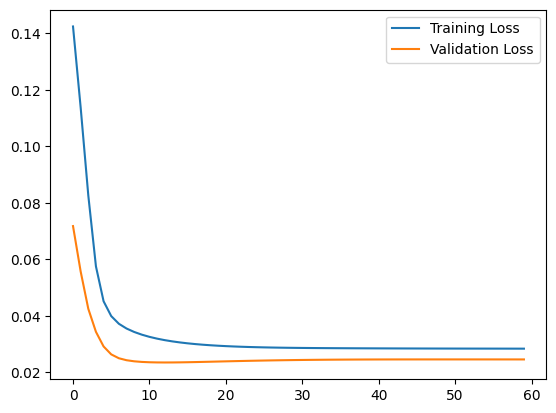

In [ ]:
plt.plot(trainingloss, label = 'Training Loss')
plt.plot(val_loss, label ='Validation Loss')
#plt.title(label= 'Training Loss for sequence length 100 ')
plt.legend()
plt.show()

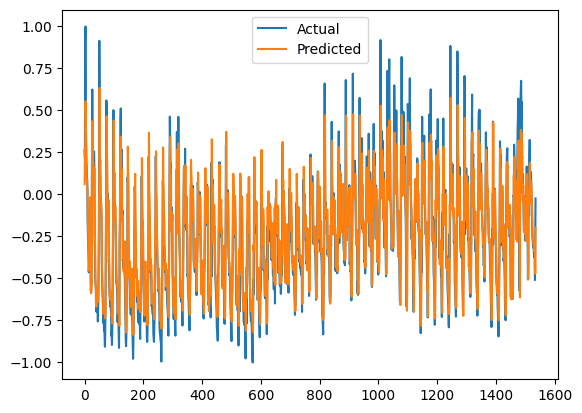

In [ ]:
with torch.no_grad():
  predicted = model(X_train).numpy()

plt.plot(y_train, label = 'Actual')
plt.plot(predicted, label ='Predicted')
plt.legend()
plt.show()

In [ ]:
##Now testing on anomalous datasets

Xtest1, ytest1 = create_dataset(
  df2[['value']],
  df2.value,
  TIME_STEPS
)

Xtest1 = torch.tensor(Xtest1).float()
ytest1 = torch.tensor(ytest1).float()

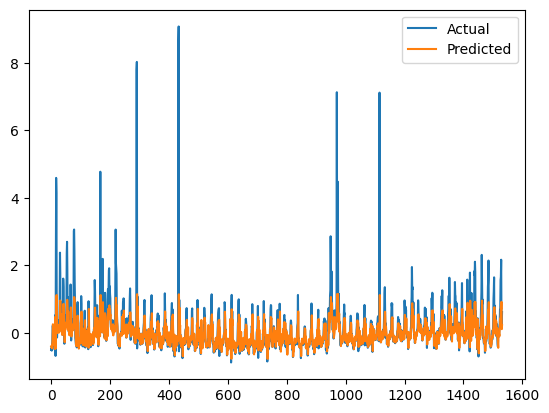

In [ ]:
with torch.no_grad():
  predicted2 = model(Xtest1).numpy()

plt.plot(ytest1, label = 'Actual')
plt.plot(predicted2, label ='Predicted')
plt.legend()
plt.show()

In [ ]:
indextracker = []
difference = []
for x in range(0,len(predicted2)):
  diff = abs(ytest1[x] - predicted2[x])
  difference.append(diff)
standard_deviation = np.std(difference)
Mean = np.mean(difference)
for x in range (0,len(difference)):
 if difference[x] >3*standard_deviation+ Mean:
    indextracker.append(x)
print("The anomalous points are at" , indextracker, "The total amount of anomalies is",len(indextracker))

The anomalous points are at [16, 17, 18, 77, 167, 219, 290, 291, 432, 433, 949, 970, 973, 1115, 1422] The total amount of anomalies is 15


Checking back with the benchmark, apparently there are three anomalies. At time,

2011-07-14 10:15:01",

"2011-07-20 10:15:01",

"2011-08-13 10:15:01

In [ ]:
for x in range(0,len(indextracker)):
  print(DATA2.iloc[indextracker[x]+TIME_STEPS]['timestamp'])

2011-07-01 22:15:01
2011-07-01 23:15:01
2011-07-02 00:15:01
2011-07-04 11:15:01
2011-07-08 16:15:01
2011-07-11 11:15:01
2011-07-14 10:15:01
2011-07-14 11:15:01
2011-07-20 10:15:01
2011-07-20 11:15:01
2011-08-12 10:15:01
2011-08-13 09:15:01
2011-08-13 12:15:01
2011-08-19 18:15:01
2011-09-02 19:15:01
